In [1]:
# Author: Nivin Jose Kovukunnel

In [2]:
# Importing the necessary packages
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from os import listdir
from os.path import isfile, join
import networkx as nx
from matplotlib.animation import FuncAnimation, PillowWriter 
from math import sqrt
import numpy as np
from simplification.cutil import (
    simplify_coords,
    simplify_coords_idx,
    simplify_coords_vw,
    simplify_coords_vw_idx,
    simplify_coords_vwp,
)

[(44413.0, 131918.0), (44449.0, 132145.0), (45183.0, 133823.0), (46341.0, 135297.0), (47833.0, 136353.0), (47969.0, 136449.0), (49359.0, 137013.0), (50711.0, 137396.0), (53404.0, 137993.0), (54808.0, 138261.0), (56225.0, 138389.0), (57016.0, 138317.0), (57794.0, 138088.0), (58503.0, 137676.0), (59100.0, 137117.0), (59921.0, 135875.0), (64207.0, 127029.0), (64088.0, 126727.0), (64076.0, 126698.0), (63435.0, 125368.0), (61249.0, 122538.0), (58815.0, 120777.0), (55960.0, 120082.0), (52426.0, 120157.0), (52105.0, 120164.0), (49579.0, 120619.0), (48085.0, 121101.0), (47949.0, 121145.0), (46604.0, 122023.0), (46482.0, 122103.0), (45320.0, 123414.0), (44545.0, 124984.0), (44247.0, 126523.0), (44220.0, 126663.0), (44094.0, 128418.0), (44022.0, 129422.0), (44413.0, 131918.0)]
37


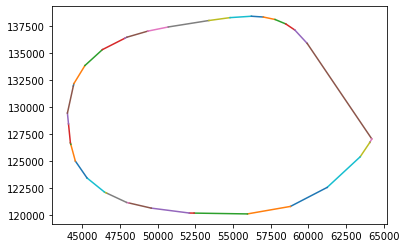

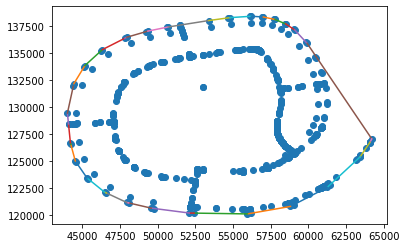

In [3]:
# Parsing input
class ObjLoader(object):
    def __init__(self, fileName):
        self.vertices = []
        self.faces = []
        ##
        try:
            f = open(fileName)
            for line in f:
                if line[:2] == "v ":
                    index1 = line.find(" ") + 1
                    index2 = line.find(" ", index1 + 1)
                    index3 = line.find(" ", index2 + 1)

                    vertex = (float(line[index1:index2]), float(line[index2:index3]), float(line[index3:-1]))
                    vertex = (round(vertex[0], 2), round(vertex[1], 2), round(vertex[2], 2))
                    self.vertices.append(vertex)

                elif line[0] == "f":
                    string = line.replace("//", "/")
                    ##
                    i = string.find(" ") + 1
                    face = []
                    for item in range(string.count(" ")):
                        if string.find(" ", i) == -1:
                            face.append(string[i:-1])
                            break
                        face.append(string[i:string.find(" ", i)])
                        i = string.find(" ", i) + 1
                    ##
                    self.faces.append(tuple(face))

            f.close()
        except IOError:
            print(".obj file not found.")




draw_line_lists = []


# Calculate the area of the triangle based on the coordinates of the three vertices of the triangle
def calc_area(a, b, c):
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    return x1 * y2 + x3 * y1 + x2 * y3 - x3 * y2 - x2 * y1 - x1 * y3


def Up(left, right, points, borders):
    # For drawing, record processing steps
    draw_line_lists.append(left)
    draw_line_lists.append(right)

    # The two points left and right_point form a straight line, and now I want to find a point on this straight line, and the triangle area required to form is the largest
    area_max = 0  # Record the area of the largest triangle

    for item in points:
        if item == left or item == right:  # The two points that make up a straight line are also in the lists collection, but they are not on the straight line, so they are not calculated.
            continue
        else:
            temp = calc_area(left, right,
                             item)  # Temporarily store the area formed by the point and the straight line for comparison in the next iteration
            if temp > area_max:
                max_point = item  # Record the point that currently constitutes the largest triangle
                area_max = temp  # Record the current largest triangle area

    if area_max != 0:  # When a line is no longer tentative, it stops, returns to the previous level, and processes the subtree of its sibling node.
        borders.append(max_point)
        Up(left, max_point, points,
           borders)  # The original left boundary point remains unchanged, the point just found to form the largest triangle is used as the right boundary point, and the recursion continues
        Up(max_point, right, points,
           borders)  # The original right boundary point remains unchanged, the point just found to form the largest triangle is used as the left boundary point, and the recursion continues


def Down(left, right, points, borders):
    """
    Same as parameters in above
    """
    draw_line_lists.append(left)
    draw_line_lists.append(right)

    area_max = 0

    for item in points:
        if item == left or item == right:
            continue
        else:
            temp = calc_area(left, right, item)
            if temp < area_max:
                max_point = item
                area_max = temp

    if area_max != 0:
        borders.append(max_point)
        Down(left, max_point, points, borders)
        Down(max_point, right, points, borders)


# Combine steps. When the execution reaches this point, the divide and conquer has ended, and the answer has been generated. The function of this function is to sort the unordered answers in a clockwise order
def order_border(points):
    """
    :param points: Unordered boundary point set
    :return: list [( , )...( , )]
    """
    points.sort()  # Sort first in the order of the x-axis to find the leftmost and rightmost points
    first_x, first_y = points[0]  # Leftmost point
    last_x, last_y = points[-1]  # Rightmost point
    up_borders = []  # Upper boundary
    dowm_borders = []  # Lower boundary
    # Analyze every point
    for item in points:
        x, y = item
        if y > max(first_y,
                   last_y):  # If it is greater than the y value of the leftmost and rightmost points, it must be in the upper half.
            up_borders.append(item)
        elif min(first_y, last_y) < y < max(first_y,
                                            last_y):  # If it is between the y values of the leftmost and rightmost points, the area of the triangle should be used to make the judgment. If the area is negative, it means that it is an inverted triangle, that is, the third point is below the line, which is the lower half; otherwise, it is the upper half.
            if calc_area(points[0], points[-1], item) > 0:
                up_borders.append(item)
            else:
                dowm_borders.append(item)
        else:  # If it is smaller than the y value of the leftmost and rightmost points, it must be in the lower half.
            dowm_borders.append(item)

    list_end = up_borders + dowm_borders[::-1]  # The boundary point of the final clockwise output
    return list_end


def draws(points, list_frames, gif_name="save.gif"):
    min_value = 0
    max_value = 100

    all_x = []
    all_y = []
    for item in points:
        a, b = item
        all_x.append(a)
        all_y.append(b)

    fig, ax = plt.subplots()  # Generate axes and figs, iterable objects
    x, y = [], []  # Used to update data after acceptance
    line, = plt.plot([], [], color="red")  # Draw a line object, plot return value type

    def init():
        # The initialization function is used to draw a clean canvas to prepare for subsequent drawing
        ax.set_xlim(min_value - abs(min_value * 0.1),
                    max_value + abs(max_value * 0.1))  # Initial function, set the drawing range
        ax.set_ylim(min_value - abs(min_value * 0.1), max_value + abs(max_value * 0.1))
        return line

    def update(points):
        a, b = points
        x.append(a)
        y.append(b)
        line.set_data(x, y)
        return line

    plt.scatter(all_x, all_y)  # Draw all the scattered points
    ani = animation.FuncAnimation(fig, update, frames=list_frames, init_func=init,
                                  interval=1500)  # interval represents the speed of drawing the connection, the larger the value, the slower the speed
    ani.save(gif_name, writer='pillow')


def show_result(points, results):
    """
    draw
    :param points: All points set
    :param results: All edge sets
    :return: picture
    """
    all_x = []
    all_y = []
    for item in points:
        a, b = item
        all_x.append(a)
        all_y.append(b)

    for i in range(len(results) - 1):
        item_1 = results[i]
        item_2 = results[i + 1]
        # Abscissa, ordinate
        one_, oneI = item_1
        two_, twoI = item_2
        plt.plot([one_, two_], [oneI, twoI])
    plt.scatter(all_x, all_y)
    plt.show()


def get_2D_points(Path):
    data = ObjLoader(Path)
    '''
        Program below is about finding projected 2D points along z axis
    '''

    # projection matrix along z axis
    projection_matrix = np.matrix([
        [1, 0, 0],
        [0, 1, 0],
    ])

    WIDTH, HEIGHT = 2000, 2000

    scale = 100
    circle_pos = [WIDTH / 2, HEIGHT / 2]  # x, y

    # variable to contain all 2D projected points
    points = []
    # convert tuple point to matrix
    for Dim3 in data.vertices:
        Dim3 = np.matrix(np.asarray(Dim3))
        points.append(Dim3)

    single_points2D = []
    # for loop to find all 2d projected points
    for point in points:
        projected2d = np.dot(projection_matrix, point.reshape((3, 1)))

        x = int(projected2d[0][0] * scale) + circle_pos[0]
        y = int(projected2d[1][0] * scale) + circle_pos[1]
        single_points2D.append((x, y))
    return single_points2D


if __name__ == "__main__":
    #folder = 'Data/'
    folder = 'C:/Users/nivin/Downloads/HULL-2-master/HULL-2-master/TestData/Model/410'
    points2D = []
    for f in listdir(folder):
        file_path = join(folder, f)
        if isfile(file_path):
            single_points2D = get_2D_points(file_path)
            for sin in single_points2D:
                points2D.append(sin)
    # First sort by the x-axis to find the leftmost and rightmost points

    points2D.sort()

    borders = []
    Up(points2D[0], points2D[-1], points2D, borders)  # Upper boundary point set
    Down(points2D[0], points2D[-1], points2D, borders)  # Lower boundary point set
    borders.append(points2D[0])
    borders.append(points2D[-1])  # Add the first and last points to the boundary point set
    #print(borders)

    results = order_border(borders)  # Clockwise boundary point
    results.append(results[0])  # Connect the last point to the source point and draw a closed line
    print(results)
    print(len(results))
    show_result([], results)
    show_result(points2D, results)  # Show static results
    

In [4]:
def Plotting_Results(points, results):
    """
    draw
    :param points: All points set
    :param results: All edge sets
    :return: picture
    """
    # defining figure size
    width = 10
    height = 10
    plt.figure(figsize=(width,height))
    
    all_x = []
    all_y = []
    
    for item in points:
        a, b = item
        all_x.append(a)
        all_y.append(b)

    for i in range(len(results) - 1):
        item_1 = results[i]
        item_2 = results[i + 1]
        # Abscissa, ordinate
        one_, oneI = item_1
        two_, twoI = item_2
        
        plt.plot([one_, two_], [oneI, twoI])
    
    
    plt.scatter(all_x, all_y)
    plt.show()

In [5]:
# Ramer–Douglas–Peucker algorithm

def calculate_distance(point_1, point_2):
    return  sqrt((point_1[0] - point_2[0]) ** 2 + (point_1[1] - point_2[1]) ** 2)


def point_line_distance(point, start, end):
    if (start == end):
        return calculate_distance(point, start)
    else:
        n = abs((end[0] - start[0]) * (start[1] - point[1]) - (start[0] - point[0]) * (end[1] - start[1]))
        d = sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
        return n / d


def Ramer_Douglas_Peucker_Algorithm(points, epsilon):
       
    distance_max = 0.0
    index = 0
    for i in range(1, len(points) - 1):
        d = point_line_distance(points[i], points[0], points[-1])
        if d > distance_max:
            index = i
            distance_max = d

    if distance_max >= epsilon:
        output = Ramer_Douglas_Peucker_Algorithm(points[:index+1], epsilon)[:-1] + Ramer_Douglas_Peucker_Algorithm(points[index:], epsilon)
        
    else:
        output = [points[0], points[-1]]

    return output

In [6]:
# The degree of coarsening is controlled by a single parameter ε, 
# which defines the maximum distance between the original points and the simplified curve.

The amount of vertices reduced using sigma value 10 is 30. This means that 7 points are removed


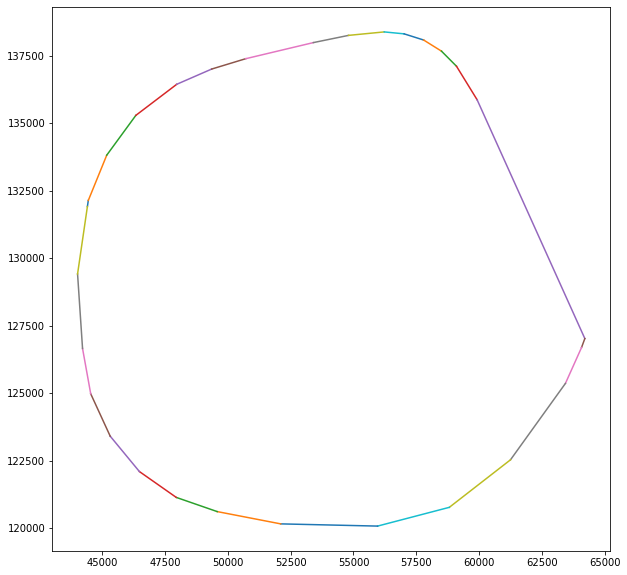

The amount of vertices reduced using sigma value 50 is 29. This means that 8 points are removed


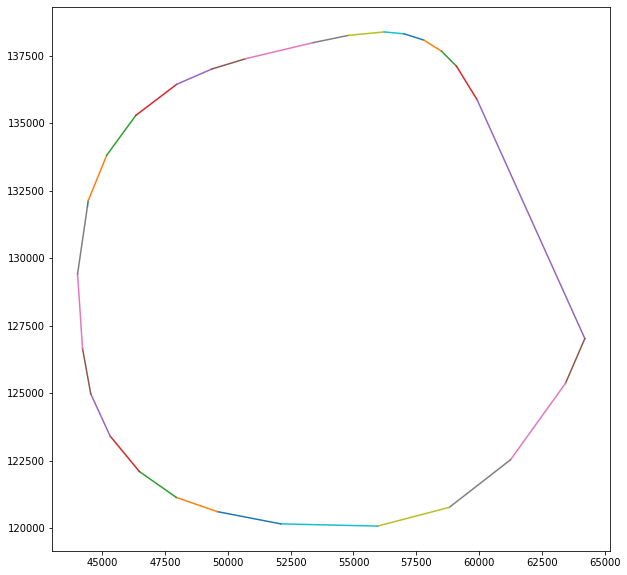

The amount of vertices reduced using sigma value 100 is 25. This means that 12 points are removed


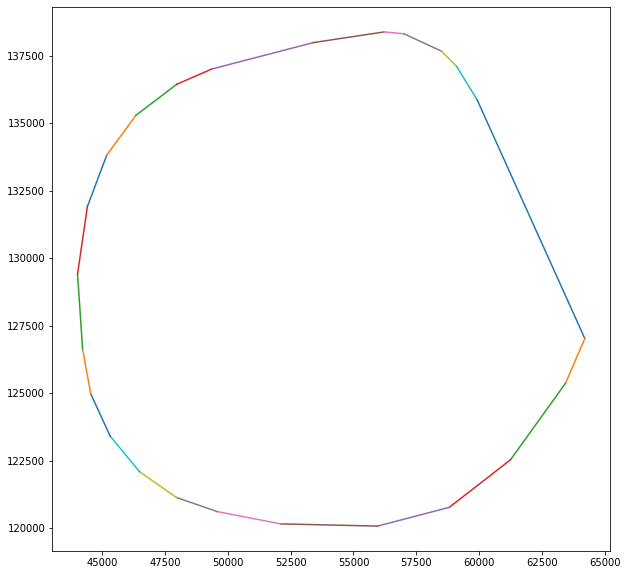

The amount of vertices reduced using sigma value 300 is 16. This means that 21 points are removed


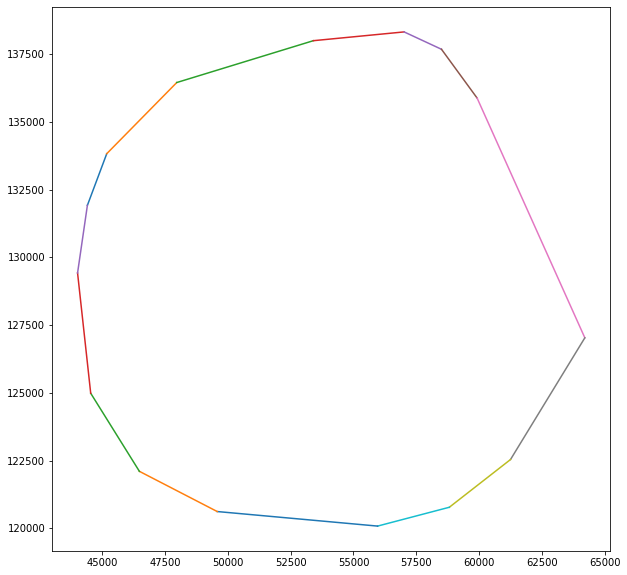

The amount of vertices reduced using sigma value 500 is 13. This means that 24 points are removed


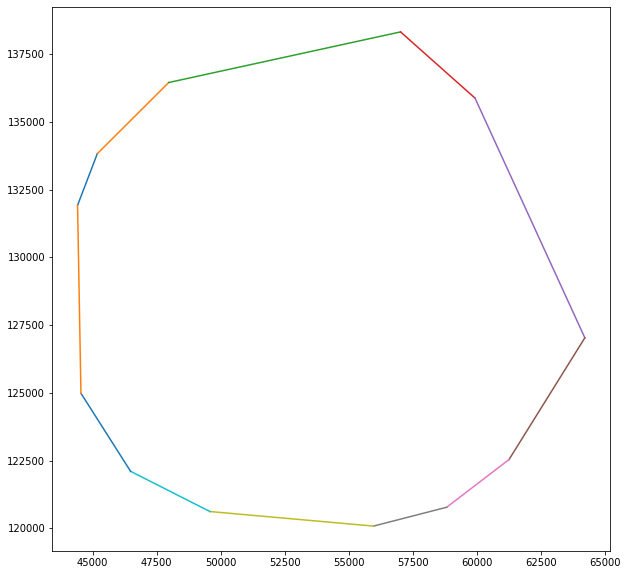

The amount of vertices reduced using sigma value 1000 is 9. This means that 28 points are removed


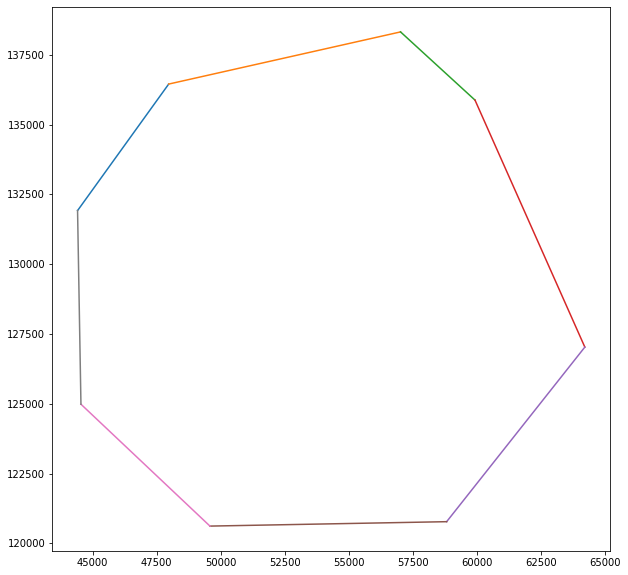

In [7]:
epsilon = [10,50,100,300,500,1000]

for eps in epsilon:
    vertex_reduced = Ramer_Douglas_Peucker_Algorithm(results, eps)
    print("The amount of vertices reduced using sigma value {} is {}. This means that {} points are removed".format(eps,len(vertex_reduced), len(results)-len(vertex_reduced)))
    Plotting_Results([],vertex_reduced)

The amount of vertices reduced using tolerance value 100 is 33. This means that 4 points are removed


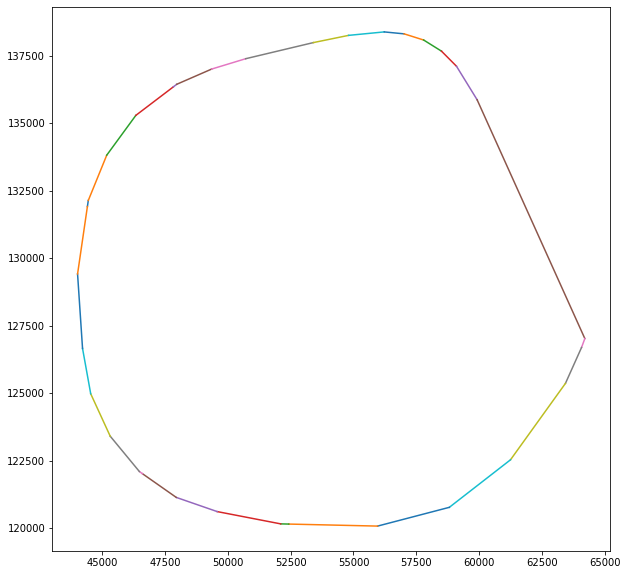

The amount of vertices reduced using tolerance value 1000 is 30. This means that 7 points are removed


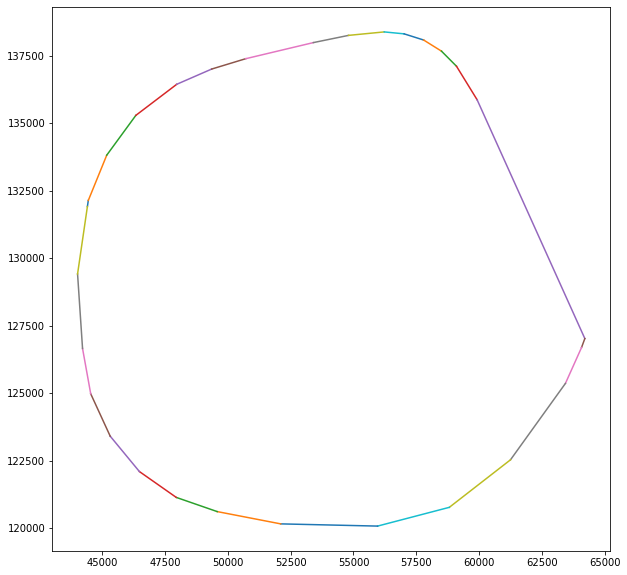

The amount of vertices reduced using tolerance value 10000 is 30. This means that 7 points are removed


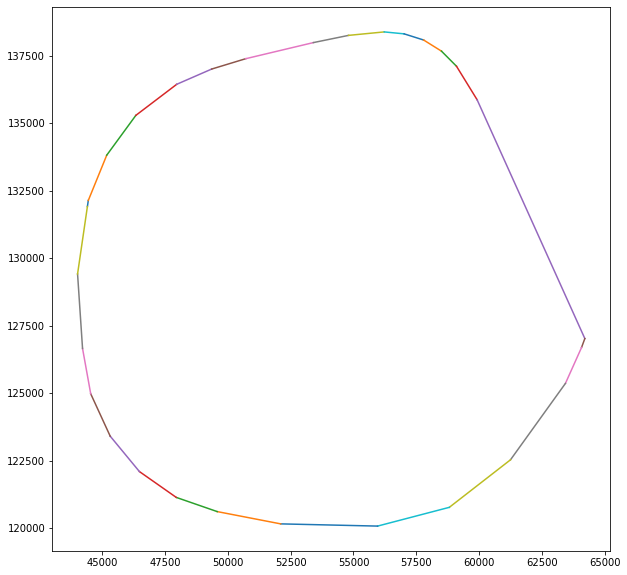

The amount of vertices reduced using tolerance value 100000 is 25. This means that 12 points are removed


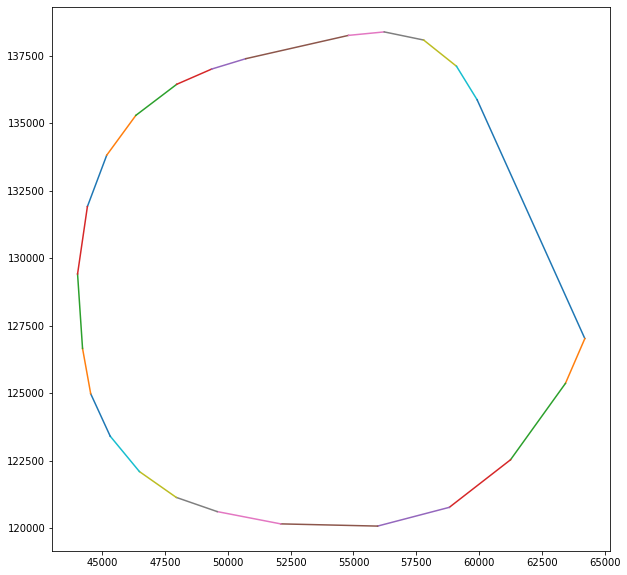

The amount of vertices reduced using tolerance value 1000000 is 16. This means that 21 points are removed


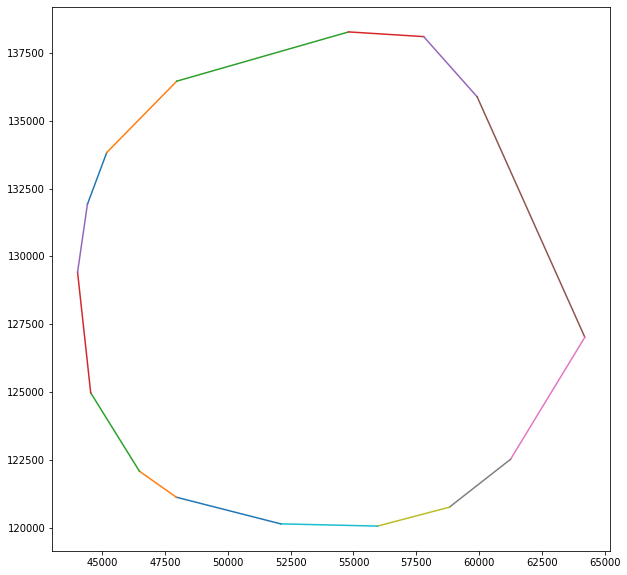

In [8]:
# Visvalingam-Wyatt algorithm

# area_tolerance : the minimum triangle area to keep a vertex in the line -> double (m²)
area_tolerance = [100,1000,10000,100000,1000000]

for area in area_tolerance:
    simplified_vw = simplify_coords_vwp(results, area)
    print("The amount of vertices reduced using tolerance value {} is {}. This means that {} points are removed".format(area,len(simplified_vw), len(results)-len(simplified_vw)))
    Plotting_Results([],simplified_vw)